In [2]:
import os, glob
import json_tricks as json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import collections
import cv2
import tqdm
from PIL import Image
import torch
import torchvision.models

import sklearn
import sklearn.metrics
from scipy.special import expit

In [3]:
1+1

2

In [4]:
import sys
sys.path.append('/home/users/jsoelter/Code/ChestImageAI/utils/')
sys.path.append('/home/users/jsoelter/Code/big_transfer/')

import data_loader, evaluations, model_setup

### Model Setup

In [6]:
model_dict =  dict(
    #architecture =  'densenet121', 
    architecture = 'BiT-M-R50x3',
    num_classes = 5,
    
    #pretrained = '/home/users/jsoelter/models/chexpert/densenet/pain2_lowr'
    pretrained = '/home/users/jsoelter/models/chexpert/dense/april_base7/step04000.pt',
    #pretrained = '/home/users/jsoelter/models/chexpert/densenet/pain_lowres2/step10500.pt',
    #pretrained = '/home/users/jsoelter/models/chexpert/densenet/resexp/lowres_big/step13902.pt',
    #pretrained = '/home/users/jsoelter/models/chexpert/fullmeta_503/step05000.pt'
    #pretrained = '/home/users/jsoelter/models/chexpert/fullmeta_503_consolidation/step00100.pt',
)

In [10]:
ledger = json.load(open(os.path.join(os.path.dirname(model_dict['pretrained']), 'train_ledger.json')))

model = model_setup.instantiate_model(**model_dict)
   
device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

BIT
Loaded pretraining weights from /home/users/jsoelter/models/chexpert/dense/april_base7/step04000.pt


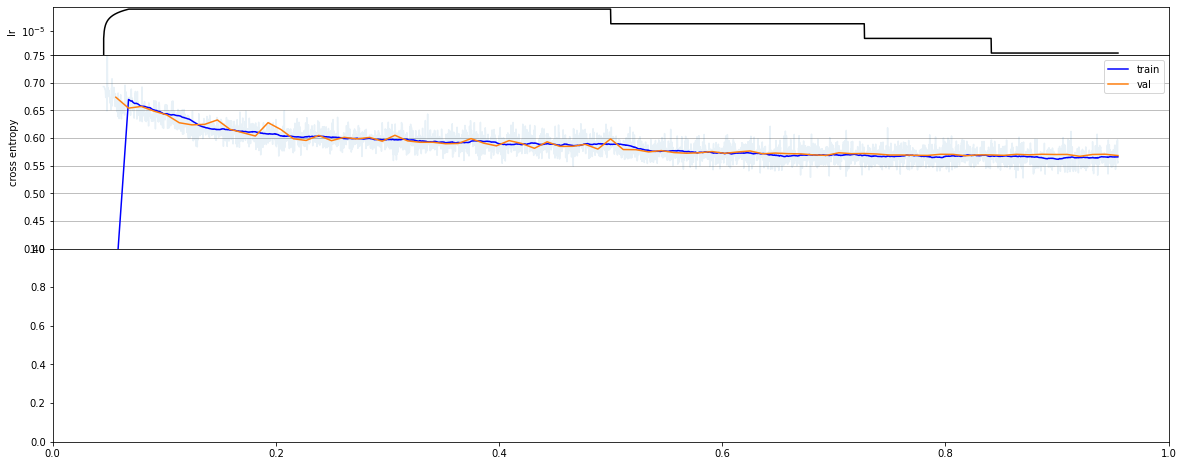

In [11]:
fig = plt.figure(figsize=(20,8)) 
gs = matplotlib.gridspec.GridSpec(3,1,height_ratios=(1,4,4), hspace=0)

ax = plt.subplot(gs[0])
plt.plot(ledger['lr'], 'k')
plt.xticks([])
plt.ylabel('lr')
plt.yscale('log')
#plt.xlim([0, 10000])


ax = plt.subplot(gs[1])
plt.plot(ledger['train_loss'], alpha=0.1) #, np.hstack([np.zeros(99), np.ones(100)/100]), mode = 'same'))
plt.plot(np.convolve(ledger['train_loss'], np.hstack([np.zeros(99), np.ones(100)/100]), mode = 'same'), color='b', label='train')
plt.plot(*np.array(ledger['internal']).T, '-', label='val')
#plt.yscale('log')
plt.ylim([0.4, 0.75])
plt.legend()
plt.grid()
#plt.yscale('log')
plt.ylabel('cross entropy')
plt.xticks([])


ax = plt.subplot(gs[2])
#plt.plot(*np.array(ledger['external']).T, 'x-')
#plt.hlines(np.array(ledger['external'])[-20:, 1].mean(), *plt.gca().get_xlim(), 'k', linestyles=':')
#final = np.array(ledger['external'])[-30:, 1] 
#print(f'{final.mean():.3f} +/- {final.std():.3f}')

### Data Setup

In [13]:
data_setup = dict(
    include_meta = [],
    #include_meta = ['Sex', 'AP/PA', 'Frontal/Lateral'],
    label_value_map = {
       #0: 0.05,
       'nan': 0.1,
       -1.: 0.5,
       #1: 0.9
    },
    fill_hierachy = {
        #'Enlarged Cardiomediastinum': ['Cardiomegaly'],
        #'Consolidation': ['Pneumonia'],
        #'Lung Opacity': ['Edema', 'Pneumonia', 'Consolidation', 'Lung Lesion', 'Atelectasis']
    },
    labels = ['Cardiomegaly', 'Edema',  'Consolidation', 'Atelectasis', 'Pleural Effusion'],
    subset = {}, # Define subsetting of data
)

In [14]:
transforms = ledger['train_setup']['0']['transforms']

In [15]:
preprocess = data_loader.transform_pipeline_from_dict(transforms)

data = data_loader.ChexpertData('CheXpert-v1.0/train.csv', transform=preprocess, **data_setup)
internal_valid_data, train_data = torch.utils.data.random_split(data, [1000, len(data)-1000], generator=torch.Generator().manual_seed(42))
external_valid_data = data_loader.ChexpertData('CheXpert-v1.0/valid.csv', 
    transform=preprocess, include_meta=data_setup['include_meta'], labels = data.labels)

Removed 0 entries
Removed 0 entries


In [16]:
computational_setup = dict(
    num_workers = 8,
    batch_size = 16
)

train_loader = torch.utils.data.DataLoader(train_data, **computational_setup)
valid_int_loader = torch.utils.data.DataLoader(internal_valid_data, **computational_setup)
valid_ext_loader = torch.utils.data.DataLoader(external_valid_data, **computational_setup)

### Benchmark

In [17]:
external_pred_ens, external_tar = evaluations.batch_prediction(model, valid_ext_loader, 
    tta_ensemble = 1, device=device)
external_pred = evaluations.ensemble_mean(external_pred_ens)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2aab4405e320>
Traceback (most recent call last):
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/users/jsoelter/miniconda3/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self.

Traceback (most recent call last):
  File "/home/users/jsoelter/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2386ef78ff7e>", line 2, in <module>
    tta_ensemble = 1, device=device)
  File "/home/users/jsoelter/Code/ChestImageAI/utils/evaluations.py", line 20, in batch_prediction
    logits = model(x)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torchvision/models/densenet.py", line 192, in forward
    features = self.features(x)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/users/jsoelter/miniconda3/lib/python3.7/site-packages/torch/nn/modules/

TypeError: object of type 'NoneType' has no len()

In [ ]:
to_predict = [
    ('Atelectasis', (0.825, 0.903)), 
    ('Cardiomegaly', (0.855, 0.870)), 
    ('Consolidation', (0.937, 0.933)), 
    ('Edema', (0.930, 0.944)), 
    ('Pleural Effusion',  (0.923, 0.917)), 
    ('AP/PA', 0), 
    ('Frontal/Lateral', 0), 
    ('Sex', 0)
]

for l, ref_score in to_predict:
    try:
        i = external_valid_data.targets.index(l)
        include = external_tar[:,i]>=0
        s = sklearn.metrics.roc_auc_score(external_tar[include,i], external_pred[include, i])
        print(f'{l:<18}{s:.3f}  vs. {ref_score}')
    except:
        continue
print(f'Full AUC:         {sklearn.metrics.roc_auc_score(external_tar, external_pred):.3f}')

In [ ]:
from scipy.special import expit

s_tot = 0
tars, preds = [], []
for l, ref_score in to_predict[:-3]:
    i = external_valid_data.targets.index(l)
    include = external_tar[:,i]>=0
    
    tar_by_study = pd.DataFrame(external_valid_data.meta_df.Path.str.split('/').str.get(-3))
    pred_by_study = tar_by_study.copy()

    tar_by_study['target'] = external_tar[include, i]
    tar = tar_by_study.groupby('Path').target.mean()

    pred_by_study['pred'] = expit(external_pred[include, i])
    pred = (pred_by_study.groupby('Path').pred).mean()
    
    s = sklearn.metrics.roc_auc_score(tar, pred)
    
    tars.append(tar)
    preds.append(pred)
    s_tot += s
    
    print(f'{l:<18}{s:.3f}  vs. {ref_score}')
total_auc = sklearn.metrics.roc_auc_score(np.hstack(tars), np.hstack(preds))
print(f'Average AUC: {s_tot/5:.3f}')
print(f'Full AUC:    {total_auc:.3f}')

### Compare prediction distributions

#### by target value

In [ ]:
internal_pred_ens, internal_tar = evaluations.batch_prediction(model, valid_int_loader, max_batch=50, tta_ensemble = 1, device=device)
internal_pred = evaluations.ensemble_mean(internal_pred_ens)

train_pred_ens, train_tar = evaluations.batch_prediction(model, train_loader, max_batch=50, tta_ensemble = 1, device=device)
train_pred = evaluations.ensemble_mean(train_pred_ens)

In [ ]:
selection =  ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [ ]:
train_tar

In [ ]:
values = [0,0.1,0.5,1]
pallete = ['r', 'orange', 'lightblue', 'green']
common_norm = False

def myplot(tar, p):
    split = [p[tar == m] for m in values]
    msk = [len(d)>10 for d in split]
    sns.kdeplot(
        data=[s for (s, m) in zip(split, msk) if m],
        palette=[s for (s, m) in zip(pallete, msk) if m],
        common_norm=common_norm, cut=True)
    plt.xlim([0,1])

for l in selection:
    col = np.where(np.array(data.targets) == l)[0]

    fig = plt.figure(figsize=(18,5))
    plt.suptitle(l)
    
    ax = plt.subplot(131)
    myplot(train_tar[:, col], expit(train_pred[:, col]))

    ax = plt.subplot(132)
    myplot(internal_tar[:, col], expit(internal_pred[:, col]))
    ax.set_title('int. Valid')
    
    ax = plt.subplot(133)
    myplot(external_tar[:, col], expit(external_pred[:, col]))
    ax.set_title('ext. Valid')

#### by meta data

In [ ]:
common_norm = False
split_by = 'AP/PA'

def myplot(tar, pred, dataset):
    p = expit(pred)
    if hasattr(dataset, 'dataset'):
        mcol = dataset.dataset.meta_df.loc[dataset.indices][:(len(p))][split_by]
    else:
        mcol = dataset.meta_df[:(len(p))][split_by]
    temp = pd.DataFrame(np.array([p.squeeze(), mcol, tar.squeeze()]).T, columns=['pred', 'split', 'tar'])
    sns.boxenplot(data=temp, x='tar', y='pred', hue='split', showfliers=False)
    plt.ylim((0,1))

for l in selection:
    col = np.where(np.array(data.targets) == l)[0]
    
    fig = plt.figure(figsize=(18,5))
    plt.suptitle(l)

    ax = plt.subplot(131)
    myplot(train_tar[:, col], train_pred[:, col], train_data)
    ax.set_title('Train')

    ax = plt.subplot(132)
    myplot(internal_tar[:, col], internal_pred[:, col], internal_valid_data)
    ax.set_title('int. Valid')

    ax = plt.subplot(133)
    myplot(external_tar[:, col], external_pred[:, col], external_valid_data)
    ax.set_title('ext. Valid')
    

## Explainability

In [ ]:
import gradcam
#gradcam_model = gradcam.GradCAM(model, model._modules['head']._modules['relu'])
gradcam_model = gradcam.GradCAM(model, model._modules['features']._modules['norm5'])

In [ ]:
label = 'Consolidation' #'Atelectasis' #'Sex' #'Support Devices' #'Consolidation' # #AP/PA' #'Cardiomegaly' # #''Atelectasis' #Sex #'Frontal/Lateral' #'Support Devices' #'Edema'
il = external_valid_data.targets.index(label)

error = np.abs(external_tar[:,il] - expit(external_pred[:, il]))
CP = external_tar[:,il]>0
CN = external_tar[:,il]==0

selection_mask = np.array([np.where(l == np.array(data.targets))[0] for l in selection]).squeeze()

In [ ]:
def explain(image_ids):
    for i in image_ids:
        plt.figure(figsize=(20, 4.5))
        img = external_valid_data[i][0]

        plt.subplot(141)
        plt.barh(range(len(selection)), external_tar[i,selection_mask], alpha=1, ec='g', linewidth=3, fc='none')
        plt.barh(range(len(selection)), expit(external_pred[i,selection_mask]), alpha=0.3, 
                 color=['g' if t >0 else 'r' for t in external_tar[i,selection_mask]]
        )
        _ = plt.yticks(range(len(selection)), selection)
        plt.xlim((0,1.1))

        plt.subplot(142)
        plt.imshow(img[0], cmap=plt.cm.viridis)
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(img[0], cmap=plt.cm.bone)
        plt.axis('off')

        #labels = [external_valid_data.targets[q] for q in np.where(external_tar[i,:]>0.5)[0]]
        #plt.title('\n'.join(labels))

        plt.subplot(144)
        mask, _ = gradcam_model(img.unsqueeze(0).to(device),  class_idx=il)
        heatmap, result = gradcam.utils.visualize_cam(mask, img[0])
        plt.imshow((result.T.numpy().swapaxes(0,1)+1)/2) #, cmap=plt.cm.bone)
        plt.axis('off')

In [ ]:
external_valid_data.transform = None

In [ ]:
preprocess

In [ ]:
plt.imshow(external_valid_data[1][0][:,:,0], cmap='bone')

In [ ]:
transforms = [
    ('ToPILImage', {}),
    ('Resize', {
        'size': 544
    }),   
    ('CenterCrop', {
        'size': (512, 512)
    }),
    ('Resize', {
        'size': 136
    }), 
    ('ToTensor', {})
]

In [ ]:
pp = data_loader.transform_pipeline_from_dict(transforms)

In [ ]:
external_valid_data.transform = None

In [ ]:
os.makedirs('/home/users/jsoelter/chexpert2')

In [ ]:
selection = external_valid_data.labels
selection_mask = np.array([np.where(l == np.array(data.targets))[0] for l in selection]).squeeze()

external_valid_data.meta_df['patientId'] = external_valid_data.meta_df.Path.str.split('/').str.get(-3)
for qix ,(pid, g) in enumerate(external_valid_data.meta_df.groupby('patientId')):
    num_images = len(g)
    fig = plt.figure(figsize=(20, 6*num_images))
    plt.suptitle(pid)
    for ix, i in enumerate(g.index):
        plt.subplot(num_images, 3, ix*3+1)
        plt.barh(range(len(selection)), external_valid_data[i][1][selection_mask], alpha=1, ec='g', linewidth=3, fc='g')
        plt.xlim([0,1.1])
        _ = plt.yticks(range(len(selection)), selection)
        plt.subplot(num_images, 3, ix*3+2)
        plt.imshow(external_valid_data[i][0][:,:,0], cmap='bone')
        plt.subplot(num_images, 3, ix*3+3)
        plt.imshow(pp(external_valid_data[i][0])[0], cmap='bone')
        fig.savefig(f'/home/users/jsoelter/chexpert2/{pid}.png')
        plt.close(fig)

### TP

In [ ]:
# Best CP prediction
explain(np.argsort(error*CP)[-CP.sum():][:9])

### FN

In [ ]:
# Worst CP prediction
explain(np.argsort(error*CP)[-CP.sum():][-1:-9:-1])

### False Positive

In [ ]:
# Worst CN prediction
explain(np.argsort(error*CN)[-CN.sum():][-1:-9:-1])

### TN

In [ ]:
explain(np.argsort(error*CN)[-CN.sum():][:9])

In [ ]:
tar = external_tar[:, selection_mask]
pred = expit(external_pred[:, selection_mask])
t = pd.DataFrame(tar, columns=selection)
pred_col = [s+'_pred' for s in selection]
p = pd.DataFrame(pred, columns=pred_col)

mean_pred = pd.concat([t,p], axis=1) #.groupby(['Atelectasis', 'Consolidation'])['Atelectasis_pred', 'Consolidation_pred'].mean()
#mean_pred = mean_pred[mean_pred[('Atelectasis_pred', 'count')]>3]

In [ ]:
for y in selection:
    x_vars = selection
    g = sns.PairGrid(pd.concat([t[y], p], axis=1), hue=y, x_vars=[x + '_pred' for x in  x_vars], y_vars=[y + '_pred'])
    g.map_diag(sns.histplot, color=".3")
    try:
        g.map_upper(sns.kdeplot, alpha=0.5, fill=True)
        g.add_legend()
    except:
        pass

In [ ]:
a = pd.concat([t, p, pd.DataFrame(t.sum(1), columns=['disease_count'])], axis=1)

plt.figure(figsize=(20,5))
for ix, dd in enumerate(selection):
    plt.subplot(1, len(selection), ix+1)
    aa = a.groupby([dd, 'disease_count'])[dd+'_pred'].agg(['mean', 'count'])
    tp = aa.unstack(dd)
    plt.scatter(tp.index, tp[('mean', 0)], s=tp[('count', 0)]*5, color='darkred', alpha=0.5)
    plt.scatter(tp.index, tp[('mean', 1)], s=tp[('count', 1)]*5, color='g')
    plt.xlabel('# co-disease')
    plt.ylim([0,1])
    plt.title(dd)